# Parameter estimation using MCMC

Gravitational-wave searches focus on the signal processing: first thing is to find a signal in the noisy data (which will not be a topic of this notebbok) and the second part is to estimate signal's parameters with a good accuracy. Then, signal's parameters can be translated to the astrophysical properties of the source. Here we will use a Markov chain Monte Carlo method for the parameter estimation. Here we will focus on the signals produced by the binary systems. Astrophysical motivation and possible ranges of parameters are described in [Leaci et al. (2016)](https://arxiv.org/pdf/1607.08751.pdf).

## Artificial data
Firstly we will generate an artificial data (astrophysical signal, so far without the noise).

f0_true: 165.72251075216124
ap_true: 2.3752373328934704
e_true: 0.8522720853287115
om_true: 0.7123961419909501
tps_true: 2983.3595856634197
H1_true: 2.473252082482243
H2_true: 2.1078837098807193
A0_true: 165.72251075216124
A1_true: 1.692810793316947
A2_true: 1.8031548689816967
A3_true: 1.5952417841206976
A4_true: 1.3778161650147374
Possible amplitudes ranges: A0:( 70.0 200.0 ), A1:( 0.0 3.769911184307752 ), A2:( 0.0 3.769911184307752 ), A3:( 0.0 3.392920065876977 ), A4:( 0.0 3.392920065876977 )


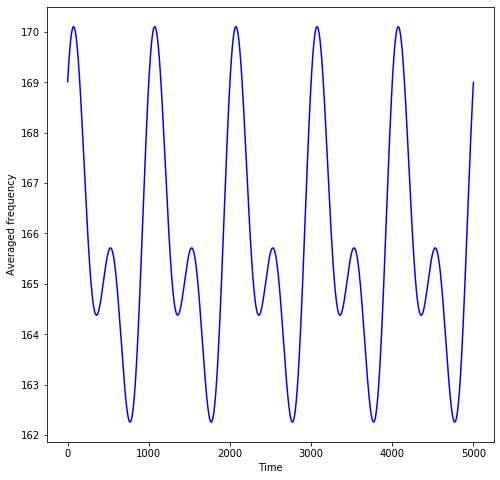

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

RANDOM_SEED = 47

# Time
N = 5000.0
sampling = 0.5
t = np.arange(0.0, N, sampling)
tmid = N/2.0

# Period of the source
# For now we set period to be known and set to reduce parameter space
P = 1000.0
Omega = 2.0*np.pi/P

# Possible ranges of the astrophysical parameters
f0min = 70.0 # [Hz]
f0max = 200.0 #[Hz]
apmin = 1.0 #[s]
apmax = 3.0 #[s]
emin = 1e-6 #[-]
emax = 0.9 #[-]
ommin = 0.0 #[rad]
ommax = np.pi #[rad]
tpmin = tmid - P/2.0
tpmax = tmid + P/2.0

# Auxiliary amplitudes
H1min = apmin*f0min*Omega
H1max = apmax*f0max*Omega
H2min = emin*H1min
H2max = emax*H1max

# Amplitudes of the signal
A0min = f0min
A0max = f0max
A1min = 0.0
A1max = H1max
A2min = 0.0
A2max = H1max
A3min = 0.0
A3max = H2max
A4min = 0.0
A4max = H2max

# True parameters - randomly chosen
f0_true = np.random.uniform(f0min, f0max) #[1/s]
ap_true = np.random.uniform(apmin, apmax) #[s]
e_true = np.random.uniform(emin, emax) #[-]
om_true = np.random.uniform(ommin, ommax) #[rad]
tps_true =  np.random.uniform(tpmin, tpmax) #[s]
print("f0_true: " + str(f0_true))
print("ap_true: " + str(ap_true))
print("e_true: " + str(e_true))
print("om_true: " + str(om_true))
print("tps_true: " + str(tps_true)) 

# Calculate true amplitudes and auxiliary amplitudes
H1_true = ap_true*f0_true*Omega
H2_true = e_true*H1_true
print("H1_true: " + str(H1_true))
print("H2_true: " + str(H2_true))
     
A0_true = f0_true #[1/s]
A1_true = H1_true/(np.sqrt((np.tan(om_true - tps_true*Omega))**2 + 1.0)) #[1/s]
A2_true = np.sqrt(H1_true**2 - A1_true**2) #[1/s]
A3_true = H2_true/np.sqrt(1.0 + (np.tan(om_true))**2) #[1/s]
A4_true = np.sqrt(H2_true**2 - A3_true**2) #[1/s]
sigma_true = 1.0 # because it's Gaussian noise
print("A0_true: " + str(A0_true))
print("A1_true: " + str(A1_true))
print("A2_true: " + str(A2_true))
print("A3_true: " + str(A3_true))
print("A4_true: " + str(A4_true))
    
print("Possible amplitudes ranges: A0:(", A0min, A0max, "), A1:(", A1min, A1max, "), A2:(", A2min, A2max, "), A3:(", A3min, A3max, "), A4:(", A4min, A4max, ")")

# Averaged frequency
f = A0_true + (A1_true*np.cos(Omega*t) + A2_true*np.sin(Omega*t)) + (A3_true*np.cos(2.0*Omega*t) + A4_true*np.sin(2.0*Omega*t))

# Visualise the data
fig = plt.figure(figsize = (8,8))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0]) 
ax1.plot(t, f, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Averaged frequency')
plt.show()

Let us add some noise to the data:

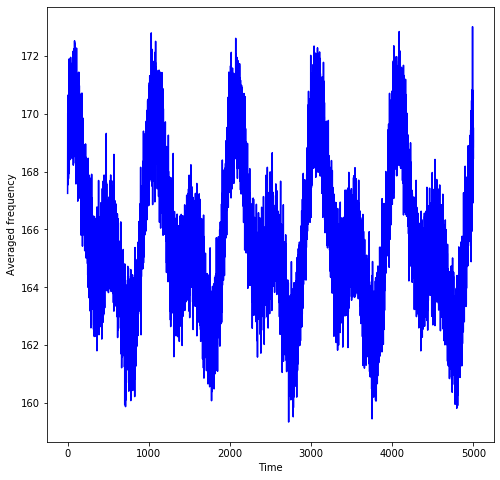

In [2]:
noise = sigma_true*np.random.randn(len(t))
f_n = f + noise

# Visualise the noisy data
fig = plt.figure(figsize = (8,8))
gs = gridspec.GridSpec(1, 1)
ax2 = plt.subplot(gs[0]) 
ax2.plot(t, f_n, color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Averaged frequency')
plt.show()

## MCMC model

Now let us build the model. Note that directly from the data we can estimate amplitudes and then, from these amplitudes, estimate astrophysical parameters (called deterministic parameters).

In [3]:
from theano import tensor as tt
import pymc3 as pm

# Build a model
basic_model = pm.Model()

with basic_model:
# Priors for unknown model parameters    
    A0 = pm.Uniform("A0", lower = A0min, upper = A0max) #[1/s]
    A1 = pm.Uniform("A1", lower = A1min, upper = A1max) #[1/s]
    A2 = pm.Uniform("A2", lower = A2min, upper = A2max) #[1/s]
    A3 = pm.Uniform("A3", lower = A3min, upper = A3max) #[1/s]
    A4 = pm.Uniform("A4", lower = A4min, upper = A4max) #[1/s]   
    
# Potentials force that parameter stays in the range: here we force condition H1 = sqrt(A1^2+A2^2) to be in range (H1min, H1max)
# If the parameters satisfies you constraints you add nothing otherwise you add -inf.
    constH1lower = pm.Potential('constH1lower', pm.math.switch(pm.math.gt(np.sqrt(A1**2 + A2**2), H1min), 0, -np.inf))
    constH1upper = pm.Potential('constH1upper', pm.math.switch(pm.math.lt(np.sqrt(A1**2 + A2**2), H1max), 0, -np.inf))

    constH2lower = pm.Potential('constH2lower', pm.math.switch(pm.math.gt(np.sqrt(A3**2 + A4**2), H2min), 0, -np.inf))
    constH2upper = pm.Potential('constH2upper', pm.math.switch(pm.math.lt(np.sqrt(A3**2 + A4**2), H2max), 0, -np.inf))

    constA0lower = pm.Potential('constA0lower', pm.math.switch(pm.math.gt(A0, A0min), 0, -np.inf))
    constA0upper = pm.Potential('constA0upper', pm.math.switch(pm.math.lt(A0, A0max), 0, -np.inf))
    constA1lower = pm.Potential('constA1lower', pm.math.switch(pm.math.gt(A1, A1min), 0, -np.inf))
    constA1upper = pm.Potential('constA1upper', pm.math.switch(pm.math.lt(A1, A1max), 0, -np.inf))
    constA2lower = pm.Potential('constA2lower', pm.math.switch(pm.math.gt(A2, A2min), 0, -np.inf))
    constA2upper = pm.Potential('constA2upper', pm.math.switch(pm.math.lt(A2, A2max), 0, -np.inf))
    constA3lower = pm.Potential('constA3lower', pm.math.switch(pm.math.gt(A3, A3min), 0, -np.inf))
    constA3upper = pm.Potential('constA3upper', pm.math.switch(pm.math.lt(A3, A3max), 0, -np.inf))
    constA4lower = pm.Potential('constA4lower', pm.math.switch(pm.math.gt(A4, A4min), 0, -np.inf))
    constA4upper = pm.Potential('constA4upper', pm.math.switch(pm.math.lt(A4, A4max), 0, -np.inf))
        
# Astrophysical parameters
    f0 = pm.Deterministic("f0", A0)
    ap = pm.Deterministic("ap", np.sqrt(A1**2 + A2**2)/(A0*Omega))
    e = pm.Deterministic("e", np.sqrt(A3**2 + A4**2)/np.sqrt(A1**2 + A2**2))
    om = pm.Deterministic("omega", np.arctan(A4/A3))
    tps = pm.Deterministic("tps", (1.0/Omega)*(om - np.arctan(A2/A1)))
    
# Expected value of outcome
    mu = A0 + (A1*np.cos(Omega*t) + A2*np.sin(Omega*t)) + (A3*np.cos(2.0*Omega*t) + A4*np.sin(2.0*Omega*t))
    regression = pm.Deterministic("regression", A0 + (A1*pm.math.cos(Omega*t) + A2*pm.math.sin(Omega*t)) + (A3*pm.math.cos(2.0*Omega*t) + A4*pm.math.sin(2.0*Omega*t)))
# Outcome without the noise    
    Y_obs = pm.Normal("f_obs", mu = regression, observed = f)
# Outcome with the noise    
#    Y_obs = pm.Normal("f_obs_n", mu = regression, observed = f_n)
    
# Instantiate sampler
# Available types: NUTS, HamiltonianMC, Metropolis, BinaryMetropolis, BinaryGibbsMetropolis, Slice, CategoricalGibbsMetropolis, PGBART (https://docs.pymc.io/api/inference.html)
# Best way to step: NUTS - adaptive version of the HamiltonianMC that automatically tunes the step size and number of the fly
# target_accept  should be 0.6-0.9
    step = pm.NUTS(target_accept=0.8)
    
# Draw 1000 posterior samples
    trace = pm.sample(100, step=step, chains=2, cores=2, random_seed=RANDOM_SEED, return_inferencedata=False)
    
# Posterior predictive checks (https://docs.pymc.io/notebooks/posterior_predictive.html)       
    ppc = pm.sample_posterior_predictive(trace, var_names=["f0", "ap", "e", "omega", "tps", "A0", "A1", "A2", "A3", "A4", "f_obs"], random_seed=RANDOM_SEED)    
#    ppc = pm.sample_posterior_predictive(trace, var_names=["f0", "ap", "e", "omega", "tps", "A0", "A1", "A2", "A3", "A4", "f_obs_n"], random_seed=RANDOM_SEED) 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A4, A3, A2, A1, A0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 14 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
/home/magdalena/anaconda2/envs/mypython3/lib/python3.8/site-packages/pymc3/sampling.py:1698: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


Now let us check how well our model works:

In [4]:
import arviz as az
with basic_model:
    print(az.summary(trace, var_names=["f0", "ap", "e", "omega", "tps", "A0", "A1", "A2", "A3", "A4"], round_to=5))

            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
f0     165.72225  0.00979  165.70022  165.73726    0.00048  0.00034   
ap       2.37542  0.01422    2.35252    2.40579    0.00084  0.00059   
e        0.85190  0.00799    0.83591    0.86449    0.00038  0.00027   
omega    0.71257  0.00721    0.69947    0.72679    0.00035  0.00025   
tps    -16.65155  1.56294  -19.68923  -13.71847    0.07286  0.05155   
A0     165.72225  0.00979  165.70022  165.73726    0.00048  0.00034   
A1       1.69247  0.01503    1.66287    1.71845    0.00076  0.00054   
A2       1.80366  0.01467    1.77559    1.83119    0.00081  0.00057   
A3       1.59435  0.01659    1.56204    1.62333    0.00078  0.00056   
A4       1.37750  0.01394    1.34538    1.40082    0.00065  0.00046   

        ess_bulk   ess_tail    r_hat  
f0     416.27546  128.71098  1.00950  
ap     285.04045  138.47226  1.01721  
e      431.38253  168.84156  1.01700  
omega  408.39834  178.53164  1.00160  
tps    460.20600  190.4

Note that this notebook is just a simple demonstration of the method and there is still much room for improvement. For example, as I run this code on my laptop, I wanted to do it fast (and not to kill the kernel). However, by increasing number of posterior samples (I recommend at least 1000), number of chains (e.g. to 4) and target_accept, one can obtain much better accuracy of the output.

We can also plot posterior for the astrophysical parameters:

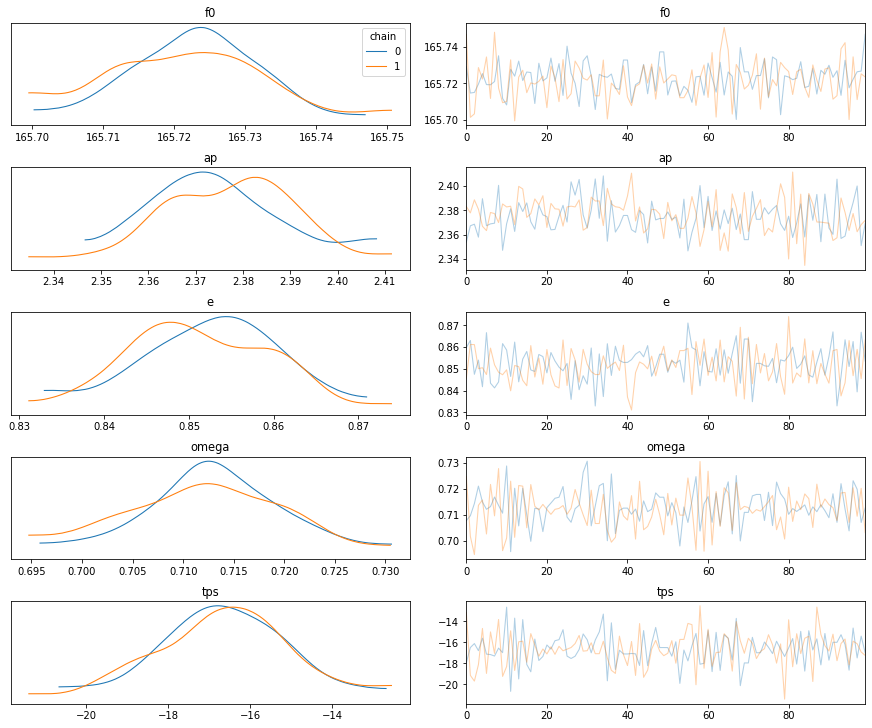

In [5]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
with basic_model:
    az.plot_trace(data=trace, var_names=["f0", "ap", "e", "omega", "tps"], compact=True, chain_prop="color", legend=True)

Above plots show traces for our MCMC. We can diagnose right panel by eye: in general, we look for a plot that shows random scatter around a mean value, and our model results suggest that the chains mixed well and the traceplot looked satisfactory. In other words we are aiming to have hairy caterpillar on the right panel (not a skinny snake or steps!).

We can visualise posterior densities and compare them with the true values:

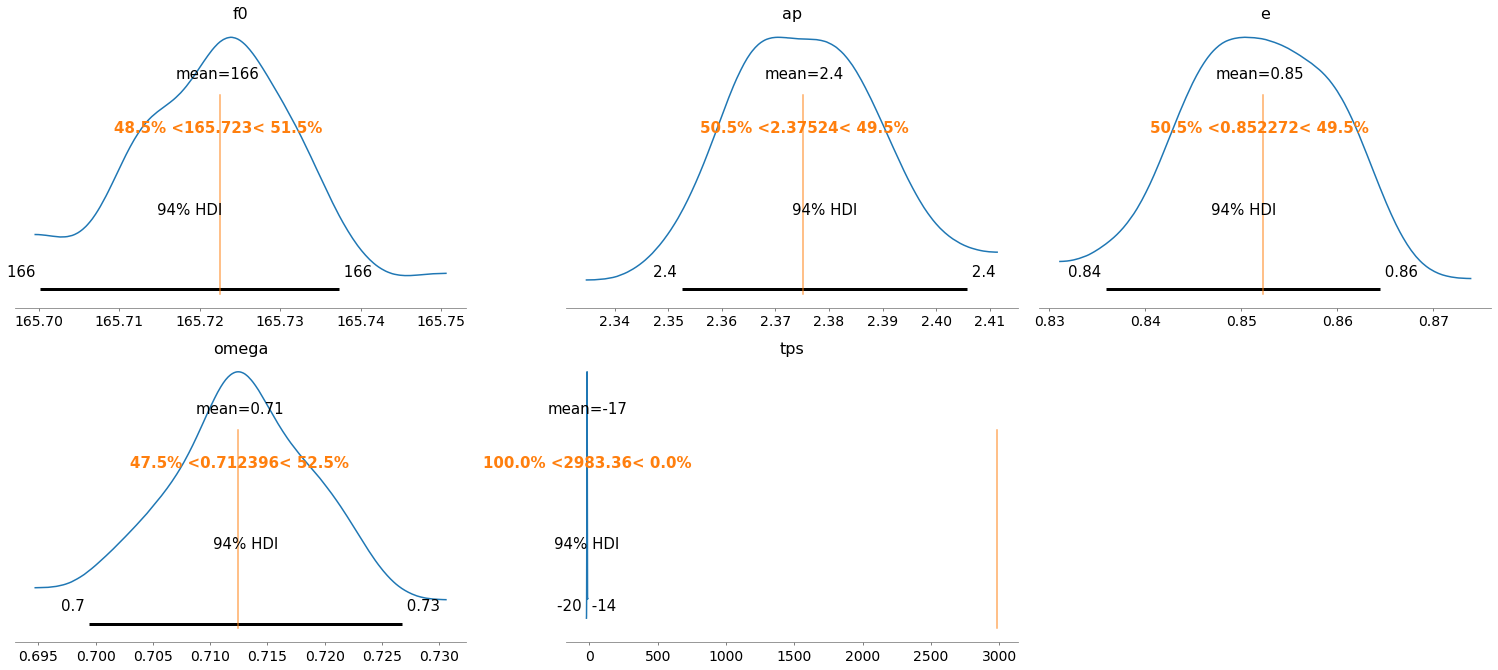

In [6]:
with basic_model:
    az.plot_posterior(trace, var_names=["f0", "ap", "e", "omega", "tps"], ref_val=[f0_true, ap_true, e_true, om_true, tps_true]) 

Posterior predictive:

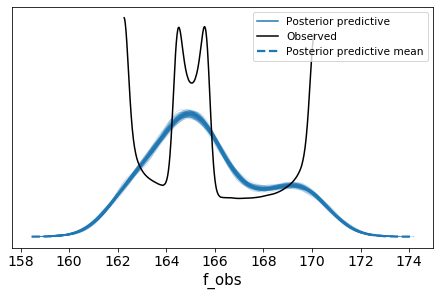

In [7]:
with basic_model:
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=basic_model), num_pp_samples=100, kind="kde")

And posterior matrix:

/home/magdalena/anaconda2/envs/mypython3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff6602ec40>,
      dtype=object)

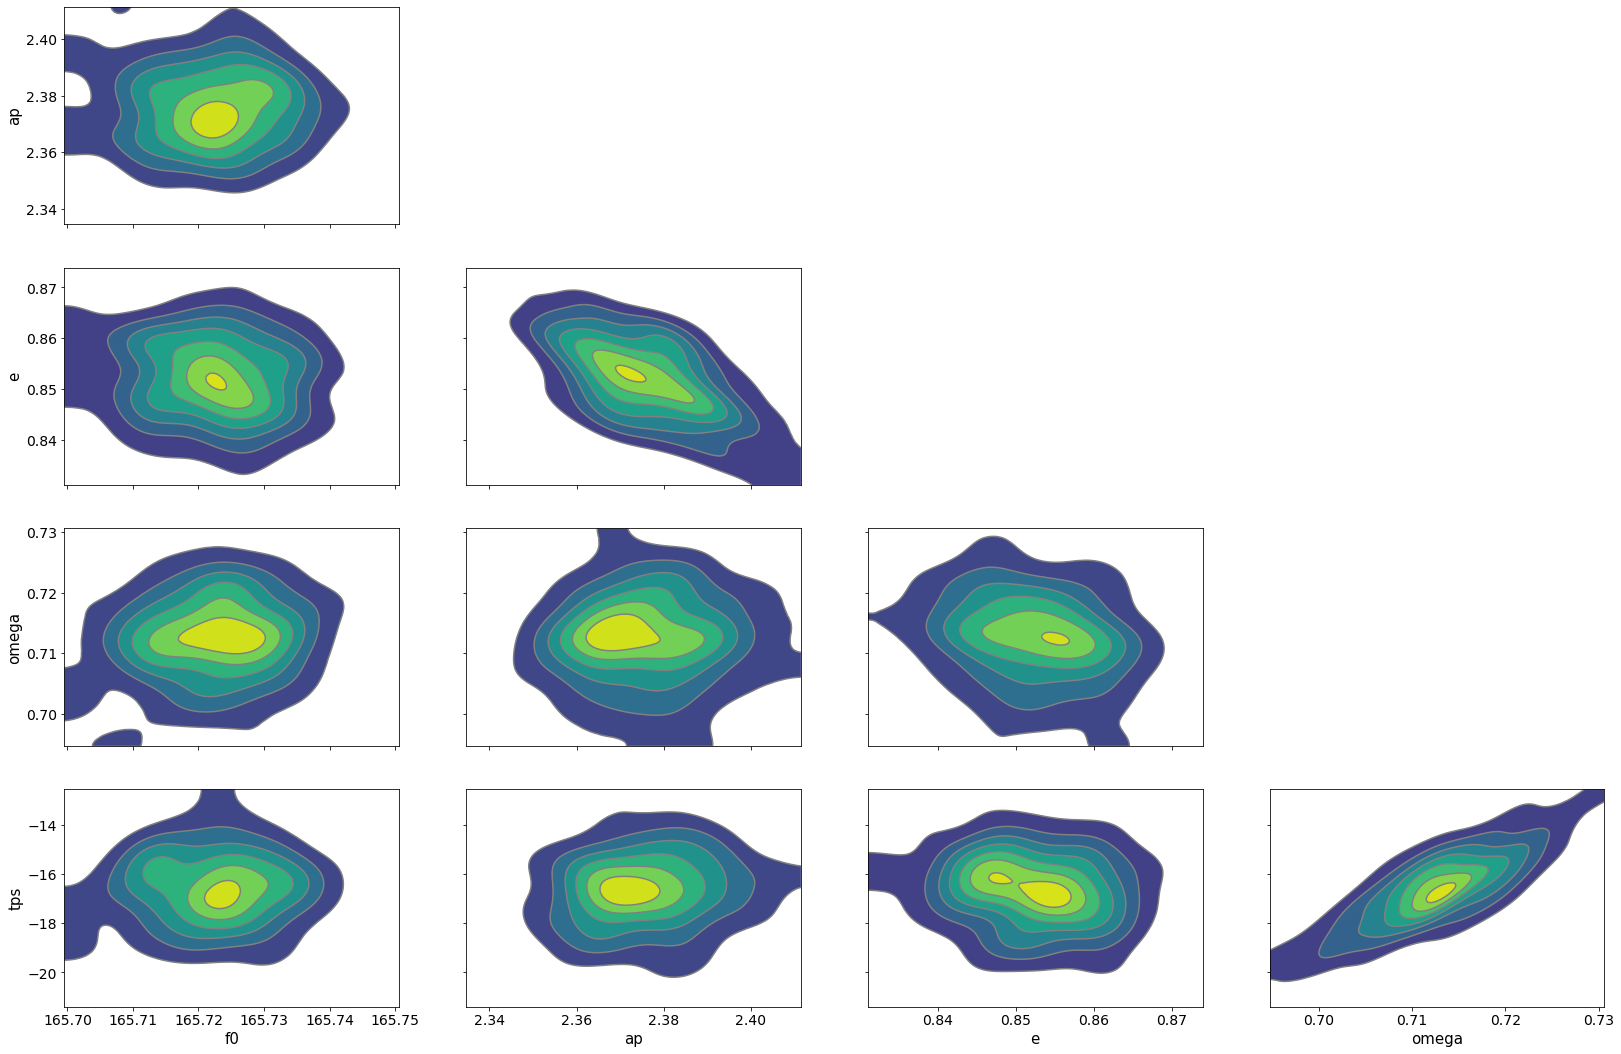

In [8]:
az.plot_pair(trace, var_names=["f0", "ap", "e", "omega", "tps"], kind='kde', contour=False)

We can see that estimation of the tps parameter is not great (and it is worth to mention that tps seems to be strongly correlated with omega). However, as I mentioned before, increasing some hyperparameters in the model architecture might improve this result.